In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)

In [2]:
SUBJECT = 'SA'

# PRE_INTERVAL = 1300
# POST_INTERVAL = 1500
# INTERVAL_SIZE = 100
# EVENT = "FeedbackOnset"

# output dir that was specified in the decode_features_with_pseudo.py
OUTPUT_DIR = "/data/patrick_res/pseudo"
HYAK_OUTPUT_DIR = "/data/patrick_res/hyak/pseudo"

SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
SESS_BEHAVIOR_PATH = "/data/rawdata/sub-SA/sess-{sess_name}/behavior/sub-SA_sess-{sess_name}_object_features.csv"

PRE_INTERVAL = 1300
POST_INTERVAL = 1500
INTERVAL_SIZE = 50
SMOOTH = 1
EVENT = "FeedbackOnset"
FEATURE_DIMS = ["Color", "Shape", "Pattern"]

In [3]:
def make_decoding_figure(accs, labels, baseline, ax, colors=None):
    for i, acc in enumerate(accs):
        visualization_utils.visualize_accuracy_across_time_bins(
            acc,
            PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
            ax,
            label=labels[i],
            right_align=True, 
            color=None if colors is None else colors[i]
        )
    ax.legend()
    # add grey band for selection period
    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    # add dotted line for feedback start
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    # add estimated chance
    ax.axhline(baseline, color='black', linestyle='dotted')


In [4]:
def get_data(session):
    behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    valid_beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(valid_beh)
    valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber")
    valid_beh_rpes = behavioral_utils.get_rpe_groups_per_session(session, valid_beh)
    fr_path = f"/data/patrick_res/firing_rates/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{SMOOTH}_smooth.pickle"
    frs = pd.read_pickle(fr_path)

    pos = spike_utils.get_unit_positions_per_sess(session)
    pos = pos.fillna("unknown")
    pos = spike_utils.get_manual_structure(pos)

    spike_times = spike_general.get_spike_times(None, SUBJECT, session, species_dir="/data")
    intervals = behavioral_utils.get_trial_intervals(valid_beh, EVENT, PRE_INTERVAL, POST_INTERVAL)
    spike_by_trial_interval = spike_utils.get_spikes_by_trial_interval(spike_times, intervals)
    spike_by_trial_interval.TrialNumber = spike_by_trial_interval.TrialNumber.astype(int)
    return frs, spike_by_trial_interval, valid_beh_rpes, pos

In [5]:
def plot_raster(unit, spike_times, beh, group_name, group_colors, group_ordering, ax):
    group_offset = 0
    unit_spikes = spike_times[spike_times.UnitID == unit]
    for group in group_ordering:
        group_beh = beh[beh[group_name] == group]
        group_beh["Y"] = np.arange(len(group_beh)).astype(int) + group_offset
        group_offset += len(group_beh)
        spikes = pd.merge(unit_spikes, group_beh, on="TrialNumber")
        spikes["X"] = (spikes.SpikeTimeFromStart - PRE_INTERVAL) / 1000
        ax.scatter(spikes.X, spikes.Y, marker="_", linewidths=1, label=group, s=1, color=group_colors[group])

### Generate Features decoding plot

In [6]:
plt.rcParams.update({'font.size': 12})

/tmp/ipykernel_3047535/328312628.py:36: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[0, 0].get_shared_x_axes().join(axs[0, 0], ax)
/tmp/ipykernel_3047535/1291780506.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_beh["Y"] = np.arange(len(group_beh)).astype(int) + group_offset
/tmp/ipykernel_3047535/1291780506.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_beh["Y"] = np.arange(len(group_beh)).astype(i

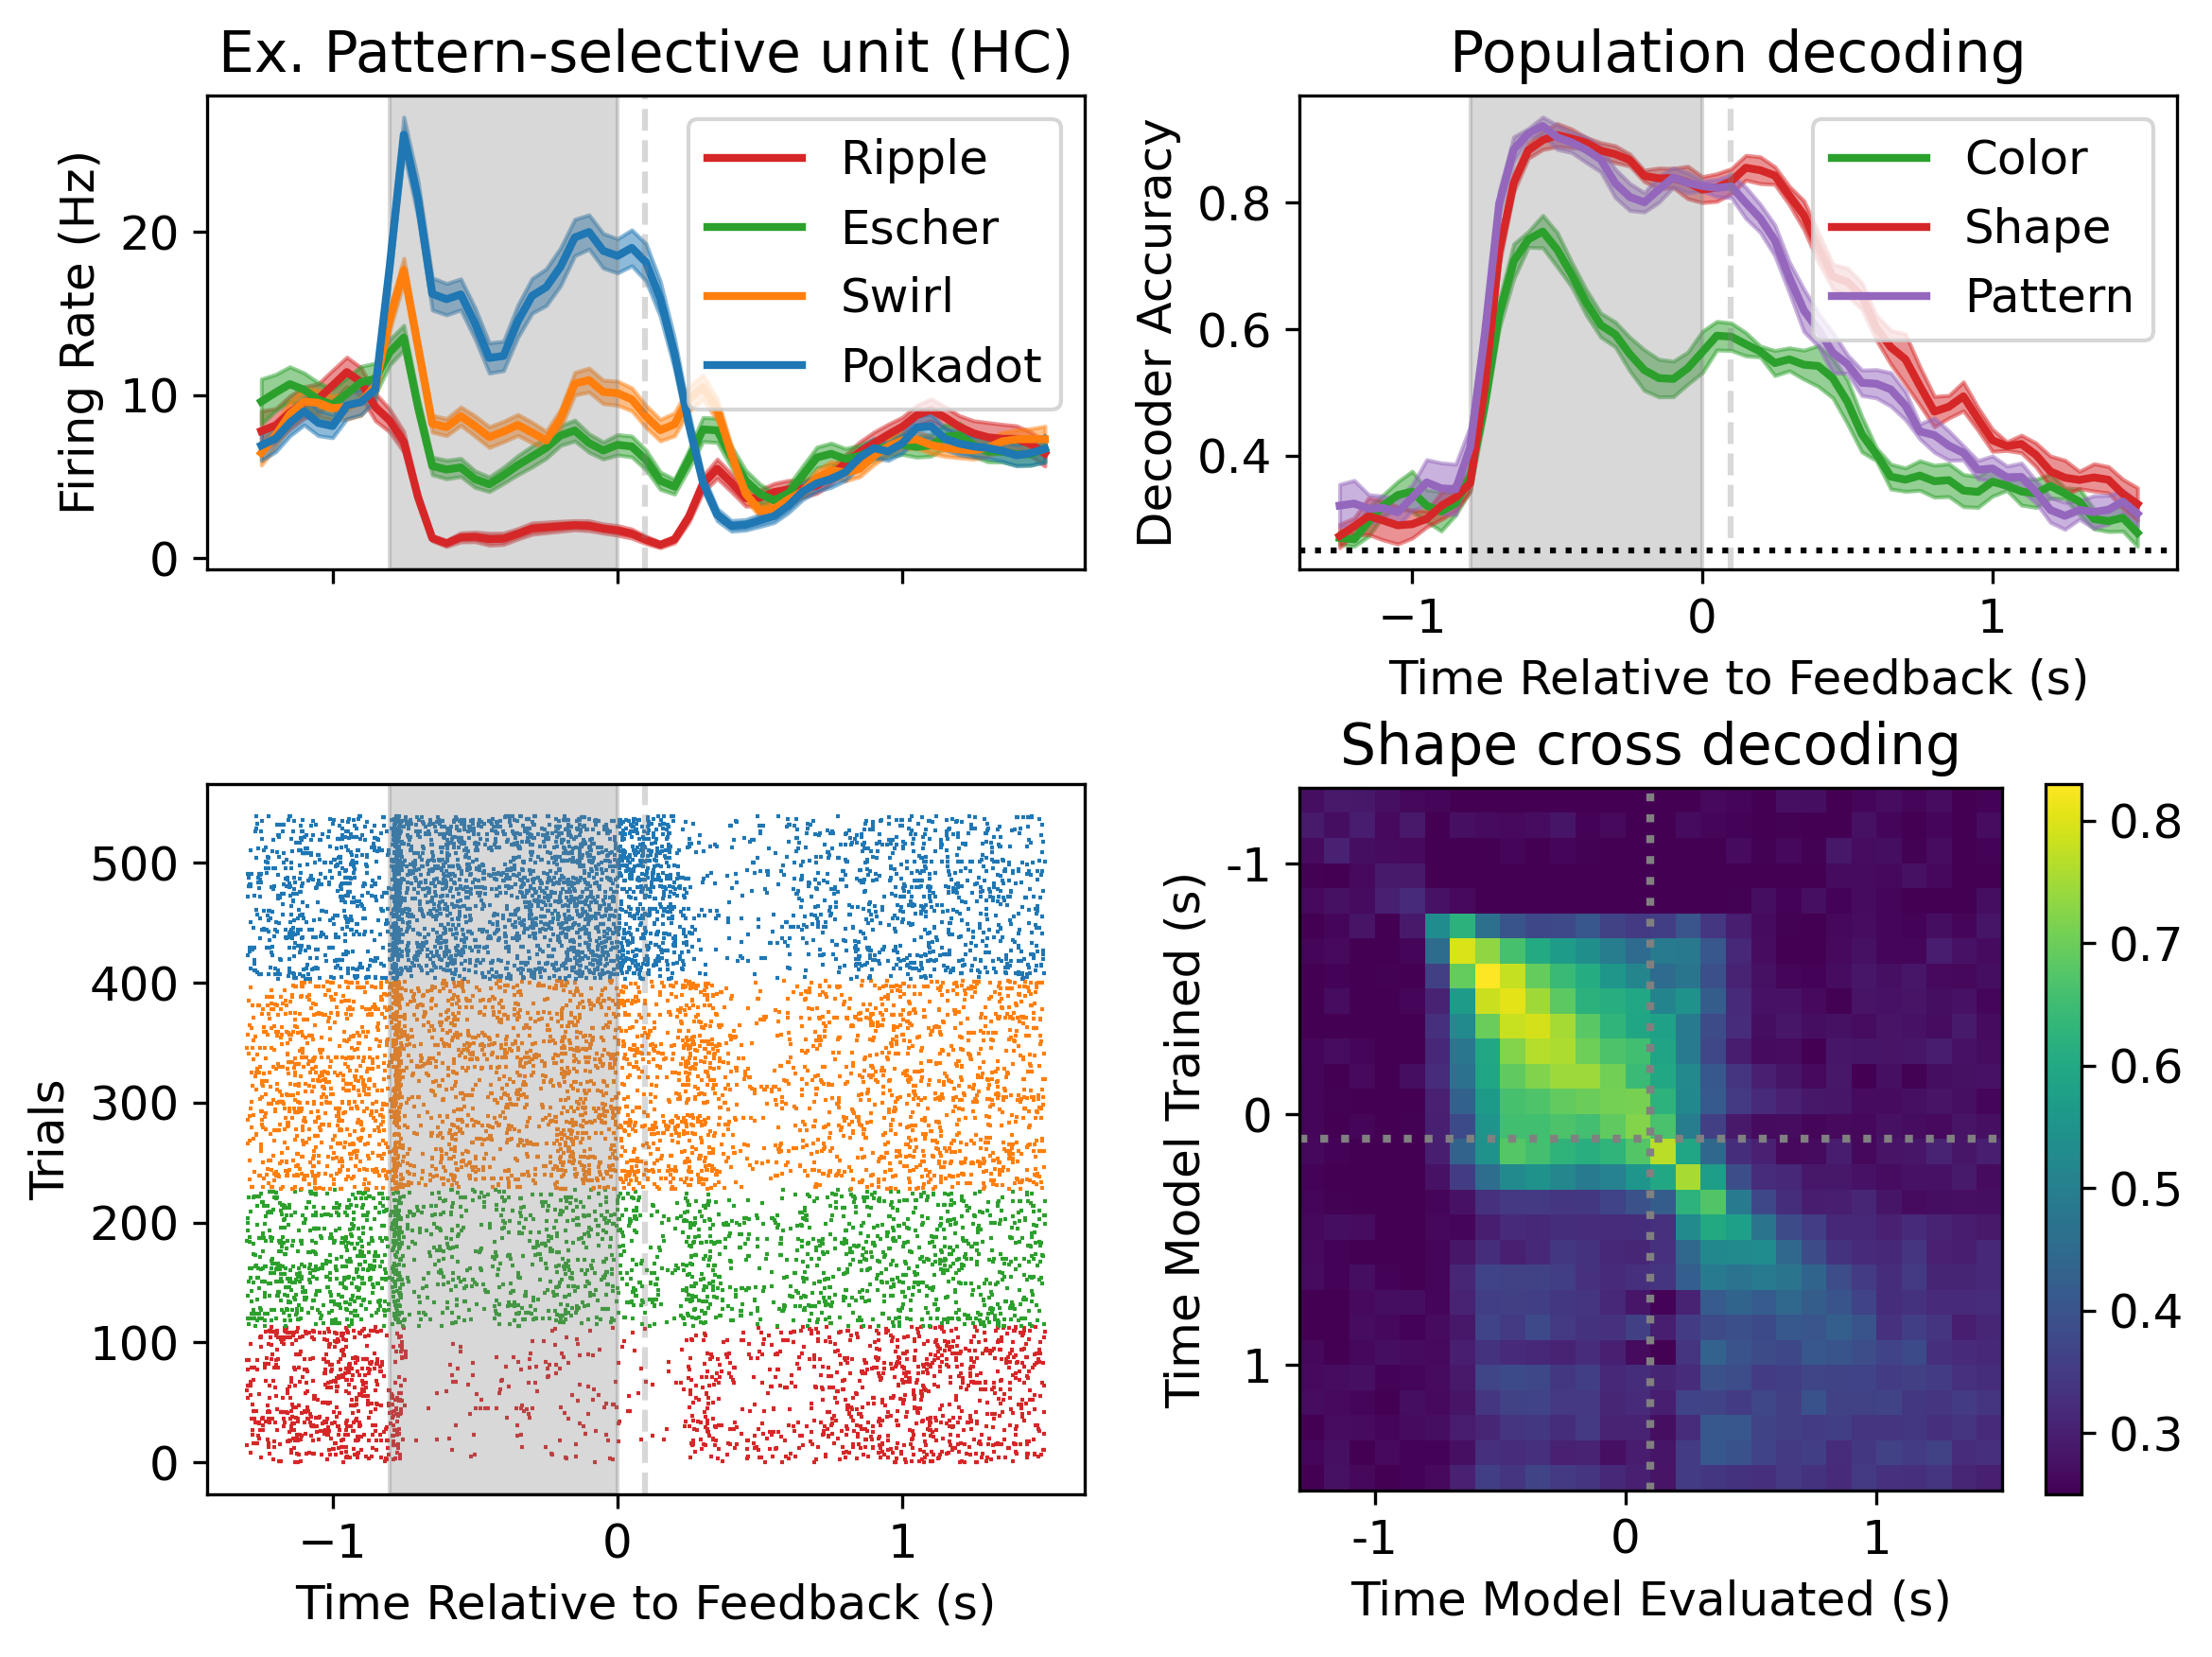

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6), gridspec_kw={'height_ratios': [2, 3]}, dpi=300)

session = "201807250001"
unit = 12
frs, spike_times, beh, pos = get_data(session)
group_name = "Pattern"
group_colors = {
    "POLKADOT": "tab:blue", 
    "SWIRL": "tab:orange", 
    "ESCHER": "tab:green", 
    "RIPPLE": "tab:red"
}
group_labels = {
    "POLKADOT": "Polkadot", 
    "SWIRL": "Swirl", 
    "ESCHER": "Escher", 
    "RIPPLE": "Ripple"  
}
# group_ordering = ["POLKADOT", "SWIRL", "ESCHER", "RIPPLE"]
group_ordering = ["RIPPLE", "ESCHER", "SWIRL", "POLKADOT"]

ax = axs[0, 0]
visualization_utils.plot_mean_frs_by_group(
    session, unit, frs, beh, group_name, pos, ax, 
    mode="FiringRate", group_colors=group_colors, group_order=group_ordering, 
    group_label=group_labels,
    set_ax=False
)
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.set_ylabel("Firing Rate (Hz)")
ax.set_title("Ex. Pattern-selective unit (HC)")


ax = axs[1, 0]
axs[0, 0].get_shared_x_axes().join(axs[0, 0], ax)
axs[0, 0].set_xticklabels([])
plot_raster(unit, spike_times, beh, group_name, group_colors, group_ordering, ax)
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')        
ax.set_ylabel("Trials")
ax.set_xlabel("Time Relative to Feedback (s)")



ax = axs[0, 1]
feature_accs = []
for feature_dim in FEATURE_DIMS:
    accs = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_all_all_no_proj_0.0_FiringRate_50_test_accs.npy"))
    feature_accs.append(accs)
make_decoding_figure(feature_accs, FEATURE_DIMS, 0.25, ax, colors=["tab:green", "tab:red", "tab:purple"])
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_title("Population decoding")

ax = axs[1, 1]
feature_dim = "Shape"
interval_size = 100
cross_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_rpe_sess_cross_accs.npy"))
colors = ax.matshow(cross_accs)
fig.colorbar(colors, ax=ax)
ratio = 1000 / interval_size
# tick_labels = np.array([-1, -0.5, 0, 0.5, 1.0, 1.5])
tick_labels = np.array([-1, 0, 1])
tick_pos = (tick_labels + 1.3) * ratio - 0.5
colors.set_clim(vmin=0.25)
# tick_labels = np.arange(len(cross_accs))
# tick_pos = np.arange(len(cross_accs))
ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels)
ax.xaxis.tick_bottom()
ax.set_yticks(tick_pos)
ax.set_yticklabels(tick_labels)
ax.set_xlabel("Time Model Evaluated (s)")
ax.set_ylabel("Time Model Trained (s)")
ax.set_title("Shape cross decoding")
# ax.set_title(f"{feature_dim} Decoders Mean Accuracies Across Timebins")
ax.axvline(13.48, color="gray", linestyle="dotted", linewidth=2)
ax.axhline(13.48, color="gray", linestyle="dotted", linewidth=2)

fig.tight_layout()
fig.savefig("/data/patrick_res/figures/feature_decoding.svg", format="svg")

### Generate RPE decoding plot

/tmp/ipykernel_3047535/2387693158.py:33: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[0, 0].get_shared_x_axes().join(axs[0, 0], ax)
/tmp/ipykernel_3047535/1291780506.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_beh["Y"] = np.arange(len(group_beh)).astype(int) + group_offset
/tmp/ipykernel_3047535/1291780506.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_beh["Y"] = np.arange(len(group_beh)).astype(

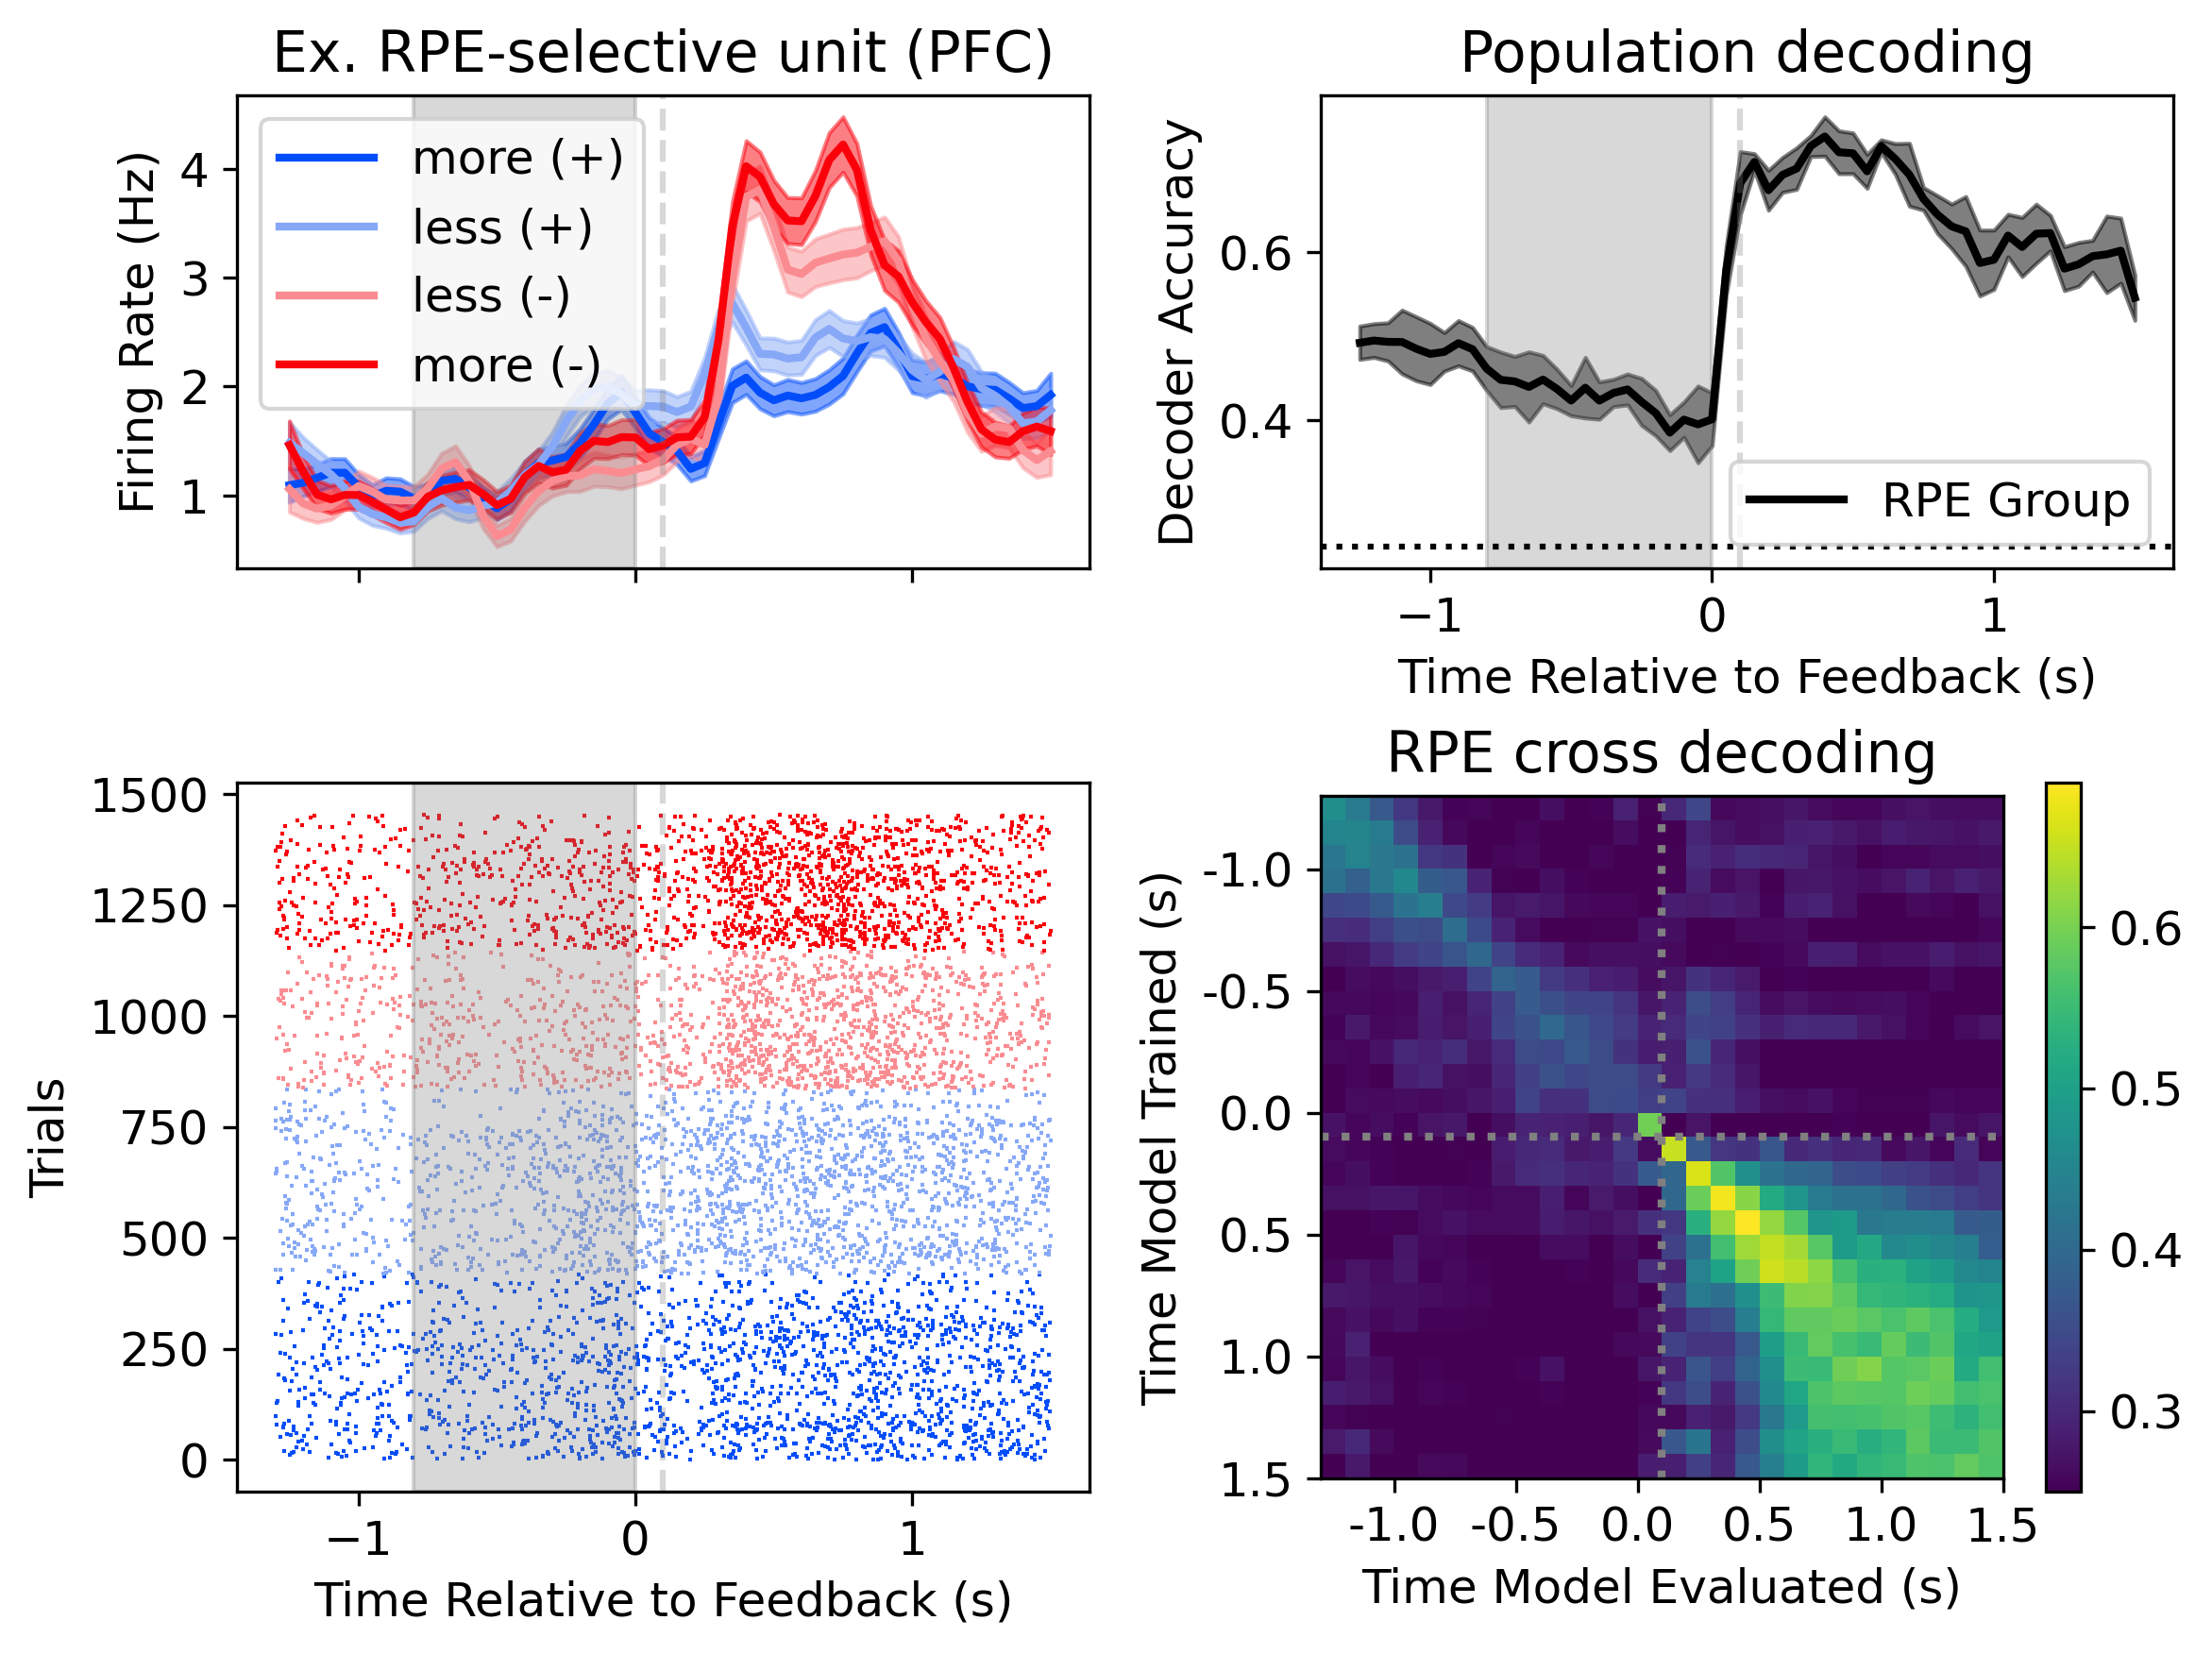

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6), gridspec_kw={'height_ratios': [2, 3]}, dpi=300)

session = "20180803"
unit = 17
frs, spike_times, beh, pos = get_data(session)
group_name = "RPEGroup"
group_colors = {
    "more pos": "#024dfa",
    "less pos": "#86a8f7",
    "less neg": "#fa8c91",
    "more neg": "#fa000b",
}
group_labels = {
    "more pos": "more (+)",
    "less pos": "less (+)",
    "less neg": "less (-)",
    "more neg": "more (-)",
}
group_ordering = ["more pos", "less pos", "less neg", "more neg"]
ax = axs[0, 0]
visualization_utils.plot_mean_frs_by_group(
    session, unit, frs, beh, group_name, pos, ax, 
    mode="FiringRate", group_colors=group_colors, 
    group_order=group_ordering, 
    group_label=group_labels,
    set_ax=False
)
ax.set_title("Ex. RPE-selective unit (PFC)")
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.set_ylabel("Firing Rate (Hz)")
ax = axs[1, 0]
axs[0, 0].get_shared_x_axes().join(axs[0, 0], ax)
axs[0, 0].set_xticklabels([])
plot_raster(unit, spike_times, beh, group_name, group_colors, group_ordering, ax)
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')        
ax.set_ylabel("Trials")
ax.set_xlabel("Time Relative to Feedback (s)")

ax = axs[0, 1]
accs = np.load(os.path.join(HYAK_OUTPUT_DIR, f"rpe_groups_all_no_proj_all_FiringRate_50_test_accs.npy"))
make_decoding_figure([accs], ["RPE Group"], 0.25, ax, colors=["black"])
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_title("Population decoding")

ax = axs[1, 1]
interval_size = 100
cross_accs = np.load(os.path.join(HYAK_OUTPUT_DIR, f"rpe_groups_cross_acc.npy"))
cross_accs = np.mean(cross_accs, axis=2)
colors = ax.matshow(cross_accs)
fig.colorbar(colors, ax=ax)
ratio = 1000 / interval_size
tick_labels = np.array([-1, -0.5, 0, 0.5, 1.0, 1.5])
tick_pos = (tick_labels + 1.3) * ratio - 0.5
colors.set_clim(vmin=0.25)
# tick_labels = np.arange(len(cross_accs))
# tick_pos = np.arange(len(cross_accs))
ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels)
ax.xaxis.tick_bottom()
ax.set_yticks(tick_pos)
ax.set_yticklabels(tick_labels)
ax.set_xlabel("Time Model Evaluated (s)")
ax.set_ylabel("Time Model Trained (s)")
ax.set_title("RPE cross decoding")
# ax.set_title(f"{feature_dim} Decoders Mean Accuracies Across Timebins")
ax.axvline(13.48, color="gray", linestyle="dotted", linewidth=2)
ax.axhline(13.48, color="gray", linestyle="dotted", linewidth=2)

fig.tight_layout()
fig.savefig("/data/patrick_res/figures/rpe_decoding.svg", format="svg")

### Make interaction figures

/tmp/ipykernel_3047535/1781839253.py:41: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[0, 0].get_shared_x_axes().join(axs[0, 0], ax)
/tmp/ipykernel_3047535/1291780506.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_beh["Y"] = np.arange(len(group_beh)).astype(int) + group_offset
/tmp/ipykernel_3047535/1291780506.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_beh["Y"] = np.arange(len(group_beh)).astype(

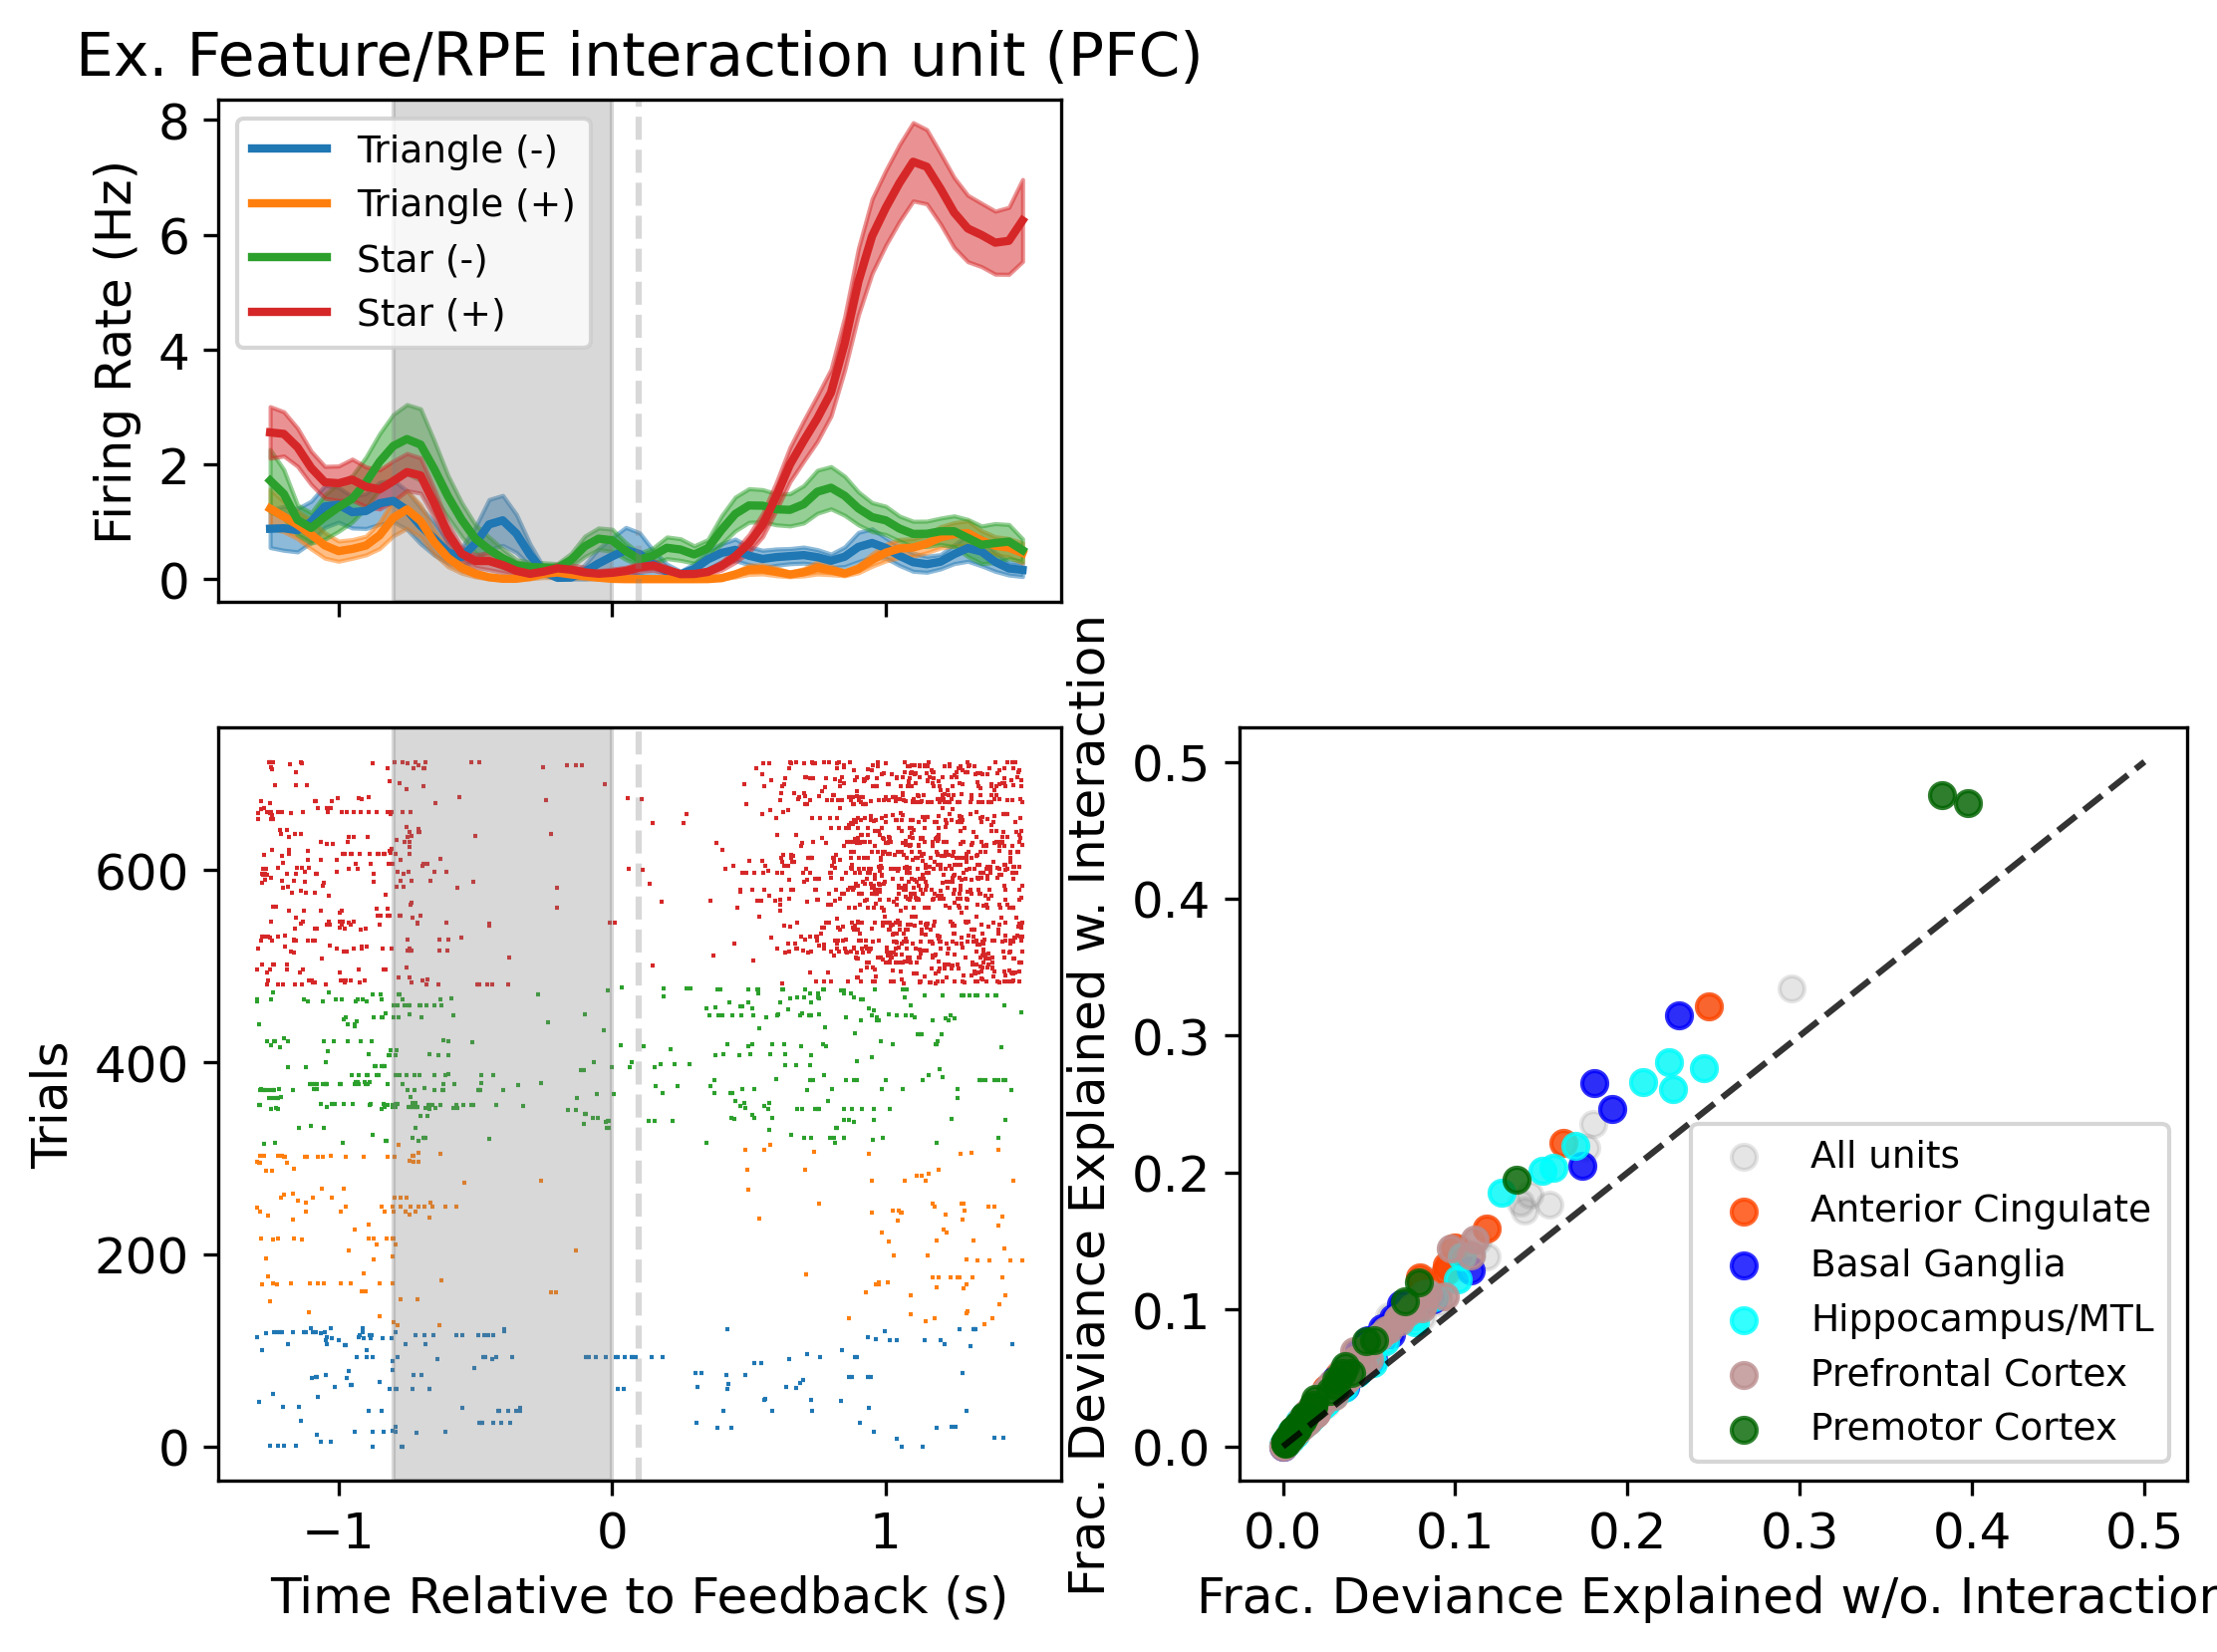

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(8.5, 6), gridspec_kw={'height_ratios': [2, 3], 'width_ratios': [4, 4.5]}, dpi=300)

session = "20180803"
unit = 30
frs, spike_times, beh, pos = get_data(session)
beh["combined"] = beh["Shape"] + " " + beh["Response"]
# sub_beh = valid_beh[valid_beh.Shape.isin(["STAR", "TRIANGLE"]) & valid_beh.RPEGroup.isin(["more pos", "less pos"])]
beh = beh[beh.Shape.isin(["STAR", "TRIANGLE"])]
group_label = {
    "TRIANGLE Incorrect": "Triangle (-)",
    "TRIANGLE Correct": "Triangle (+)",
    "STAR Incorrect": "Star (-)",
    "STAR Correct": "Star (+)",
}
group_colors = {
    "TRIANGLE Incorrect": "tab:blue", 
    "TRIANGLE Correct": "tab:orange", 
    "STAR Incorrect": "tab:green", 
    "STAR Correct": "tab:red"
}
group_name = "combined"
group_ordering = ["TRIANGLE Incorrect", "TRIANGLE Correct", "STAR Incorrect", "STAR Correct"]

# fig, axs = plt.subplots(2, 1, figsize=(5, 8), gridspec_kw={'height_ratios': [4, 6]}, sharex=True)
# group_ordering = ["POLKADOT", "SWIRL", "ESCHER", "RIPPLE"]

ax = axs[0, 0]
visualization_utils.plot_mean_frs_by_group(
    session, unit, frs, beh, group_name, pos, ax, 
    mode="FiringRate", group_colors=group_colors, group_label=group_label,
    group_order=group_ordering, set_ax=False
)
ax.legend(prop={'size': 9})
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.set_ylabel("Firing Rate (Hz)")
ax.set_title("Ex. Feature/RPE interaction unit (PFC)")


ax = axs[1, 0]
axs[0, 0].get_shared_x_axes().join(axs[0, 0], ax)
axs[0, 0].set_xticklabels([])
plot_raster(unit, spike_times, beh, group_name, group_colors, group_ordering, ax)
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')        
ax.set_ylabel("Trials")
ax.set_xlabel("Time Relative to Feedback (s)")

time_idxs = np.arange(13, 28)
# ax = axs[2]
unit_res = pd.read_pickle("/data/patrick_res/glm_unit_res.pickle")
time_unit_res = unit_res[unit_res.TimeIdxs.isin(time_idxs)]
def get_max(group):
    return group.loc[group.interaction_score.idxmax()]
maxes = time_unit_res.groupby("PseudoUnitID").apply(get_max)

ax = axs[0, 1]
ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# ax.xaxis.set_ticks_position('none')
# ax.yaxis.set_ticks_position('none')

ax = axs[1, 1]
# sig_units = maxes[maxes.interaction_score > maxes.sig_bound]
sig_units = maxes
ax.scatter(sig_units.separate_score, sig_units.interaction_score, alpha=0.2, color="gray", label="All units")
for area in ["Anterior Cingulate Gyrus", "Basal Ganglia", "Hippocampus/MTL", "Prefrontal Cortex", "Premotor Cortex"]:
    area_units = sig_units[sig_units.manual_structure == area]
    label = "Anterior Cingulate" if area == "Anterior Cingulate Gyrus" else area
    ax.scatter(area_units.separate_score, area_units.interaction_score, alpha=0.8, label=label, color=visualization_utils.REGION_TO_COLOR[area])
ax.legend(prop={'size': 9})
ax.set_ylabel("Frac. Deviance Explained w. Interaction")
ax.set_xlabel("Frac. Deviance Explained w/o. Interaction")
ax.plot(np.arange(0, 0.6, 0.1), np.arange(0, 0.6, 0.1), linestyle="--", color="black", alpha=0.8)
fig.savefig("/data/patrick_res/figures/interaction_plot.svg", format="svg")

### Residual decoding cross

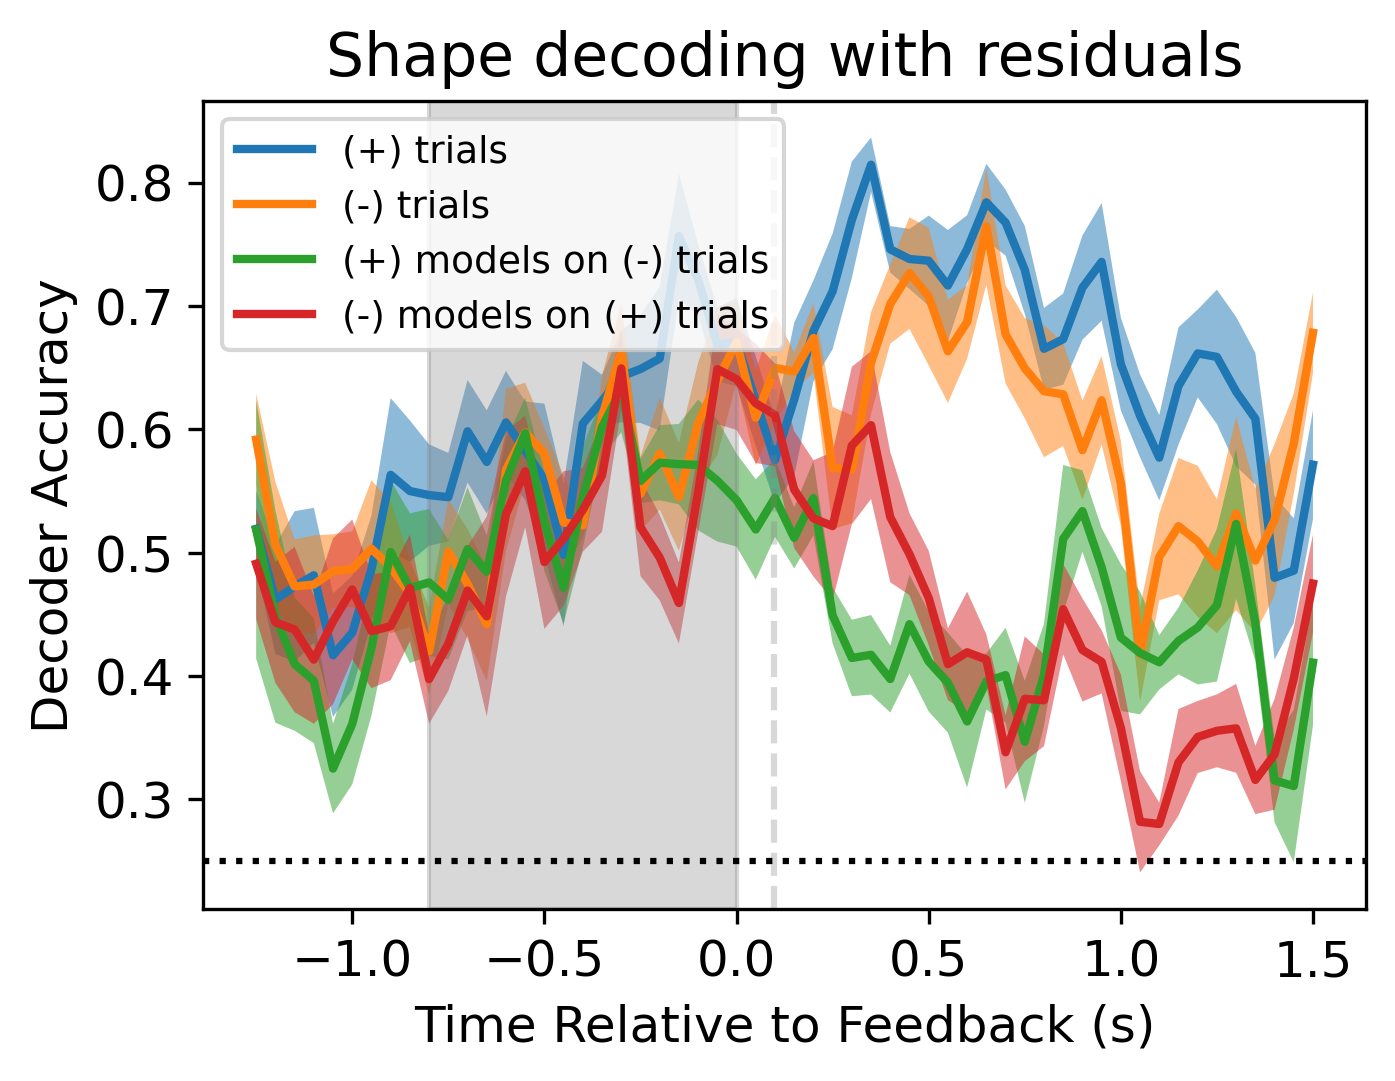

In [26]:
fig, ax = plt.subplots(dpi=300, figsize=(5, 3.5))
# all = np.load(os.path.join(HYAK_OUTPUT_DIR, f"SQUARE_vs_TRIANGLE_vs_CIRCLE_vs_STAR_Response_all_residual_fr_unshuffled_test_accs.npy"))
cor = np.load(os.path.join(HYAK_OUTPUT_DIR, f"SQUARE_vs_TRIANGLE_vs_CIRCLE_vs_STAR_Response_Correct_residual_fr_unshuffled_test_accs.npy"))
inc = np.load(os.path.join(HYAK_OUTPUT_DIR, f"SQUARE_vs_TRIANGLE_vs_CIRCLE_vs_STAR_Response_Incorrect_residual_fr_unshuffled_test_accs.npy"))
cor_model_on_inc = np.load(os.path.join(HYAK_OUTPUT_DIR, f"SQUARE_vs_TRIANGLE_vs_CIRCLE_vs_STAR_Response_Correct_residual_fr_cross_accs.npy"))
inc_model_on_cor = np.load(os.path.join(HYAK_OUTPUT_DIR, f"SQUARE_vs_TRIANGLE_vs_CIRCLE_vs_STAR_Response_Incorrect_residual_fr_cross_accs.npy"))
# visualization_utils.visualize_accuracy_across_time_bins(
#     all,
#     PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
#     ax,
#     label="All trials",
#     right_align=True, 
#     # sem=True,
# )
visualization_utils.visualize_accuracy_across_time_bins(
    cor,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label="(+) trials",
    right_align=True, 
    # sem=True,
)
visualization_utils.visualize_accuracy_across_time_bins(
    inc,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label="(-) trials",
    right_align=True, 
    # sem=True,
)
visualization_utils.visualize_accuracy_across_time_bins(
    cor_model_on_inc,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label="(+) models on (-) trials",
    right_align=True, 
    # sem=True,
)
visualization_utils.visualize_accuracy_across_time_bins(
    inc_model_on_cor,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label="(-) models on (+) trials",
    right_align=True, 
    # sem=True,
)
# visualization_utils.visualize_accuracy_across_time_bins(
#     inc_shuffled,
#     PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
#     ax,
#     label="inc shuffled",
#     right_align=True, 
# )
ax.legend(prop={'size': 9})
# ax.legend()

# add grey band for selection period
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
# add dotted line for feedback start
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
# add estimated chance
ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Decoder Accuracy")
ax.set_title("Shape decoding with residuals")
fig.savefig("/data/patrick_res/figures/residual_cor_inc.svg", format="svg")

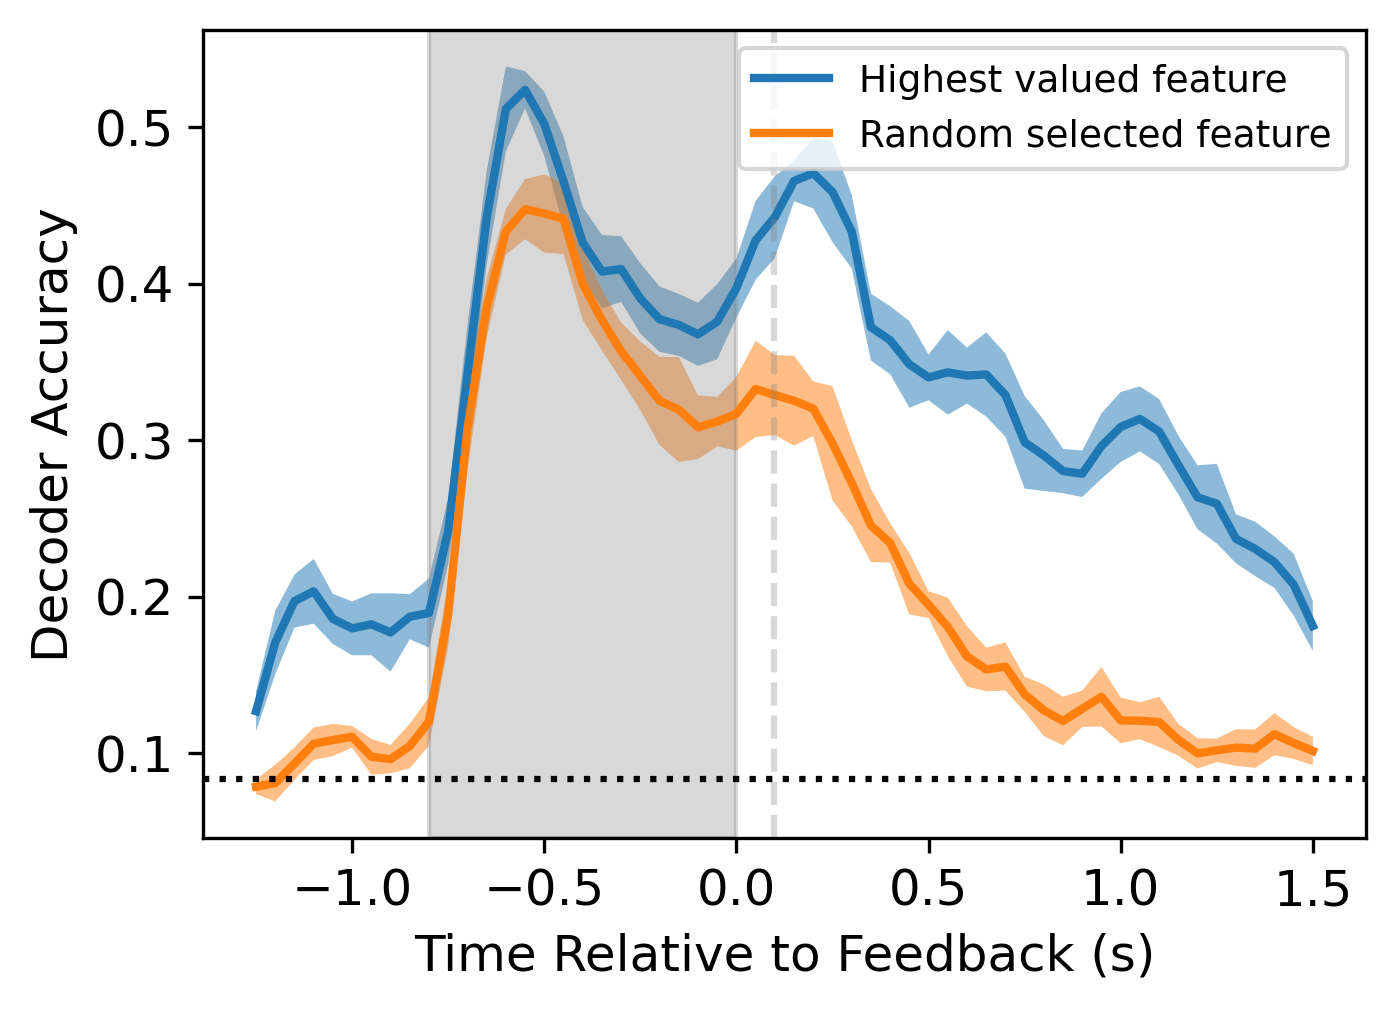

In [23]:
fig, ax = plt.subplots(dpi=300, figsize=(5, 3.5))
high_val_accs = np.load(os.path.join(HYAK_OUTPUT_DIR, "high_val_MaxFeat_all_all_base_fr_50_rpe_sess_test_accs.npy"))
random_accs = np.load(os.path.join(HYAK_OUTPUT_DIR, "high_val_RandomMaxFeat_all_all_base_fr_50_rpe_sess_test_accs.npy"))
visualization_utils.visualize_accuracy_across_time_bins(
    high_val_accs,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"Highest valued feature",
    right_align=True, 
)
visualization_utils.visualize_accuracy_across_time_bins(
    random_accs,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"Random selected feature",
    right_align=True, 
)
ax.legend(prop={'size': 9})
# add grey band for selection period
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
# add dotted line for feedback start
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
# add estimated chance
ax.axhline(1/12, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Decoder Accuracy")
fig.savefig("/data/patrick_res/figures/high_val.svg", format="svg")